<a href="https://colab.research.google.com/github/SrijaaimeenakshiM/ml-classification-hub/blob/main/multiclass_classification/food101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.15.0

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
import zipfilep
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2025-01-28 08:46:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.207, 142.250.145.207, 74.125.128.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  29.9MB/s    in 51s     

2025-01-28 08:47:43 (30.1 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
zip_ref=zipfile.ZipFile("/content/101_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os
for dirpath,dirname,filename in os.walk("/content/101_food_classes_10_percent"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in {dirpath}")


There are 2 directories and 0 images in /content/101_food_classes_10_percent
There are 101 directories and 0 images in /content/101_food_classes_10_percent/train
There are 0 directories and 75 images in /content/101_food_classes_10_percent/train/chocolate_cake
There are 0 directories and 75 images in /content/101_food_classes_10_percent/train/omelette
There are 0 directories and 75 images in /content/101_food_classes_10_percent/train/beef_tartare
There are 0 directories and 75 images in /content/101_food_classes_10_percent/train/deviled_eggs
There are 0 directories and 75 images in /content/101_food_classes_10_percent/train/croque_madame
There are 0 directories and 75 images in /content/101_food_classes_10_percent/train/carrot_cake
There are 0 directories and 75 images in /content/101_food_classes_10_percent/train/strawberry_shortcake
There are 0 directories and 75 images in /content/101_food_classes_10_percent/train/sashimi
There are 0 directories and 75 images in /content/101_food_cl

In [ ]:
train_data=tf.keras.preprocessing.image_dataset_from_directory(directory="/content/101_food_classes_10_percent/train",
                                                               batch_size=32,
                                                               image_size=(224,224),
                                                               label_mode="categorical")


test_data=tf.keras.preprocessing.image_dataset_from_directory(directory="/content/101_food_classes_10_percent/test",
                                                               batch_size=32,
                                                               image_size=(224,224),
                                                               label_mode="categorical",
                                                              shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:
# we will use data argumentation like a layer in functional api
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Create argumentation as Sequential api
data_argumentation= tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
   # preprocessing.Rescaling(1/255)# for resnet50V2
],name="data_argumentation")

In [ ]:
# creating the checkpoint
checkpoint_path="food101_checkpoint/model"

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_best_only=True,
                                                       save_weights_only=True,
                                                       monitor="val_accuracy"
                                                       )

In [ ]:
input_layer=tf.keras.layers.Input(shape=(224,224,3))
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
x=data_argumentation(input_layer)
x=base_model(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
output=tf.keras.layers.Dense(len(train_data.class_names),activation="softmax",name="output_layer")(x)
model=tf.keras.Model(input_layer,output)

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history=model.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=int(0.15*len(test_data)),
             callbacks=[checkpoint_path])

Epoch 1/5
237/237 [==============================] - 164s 645ms/step - loss: 3.3733 - accuracy: 0.2679 - val_loss: 2.6044 - val_accuracy: 0.4044
Epoch 2/5
237/237 [==============================] - 106s 444ms/step - loss: 2.2024 - accuracy: 0.5043 - val_loss: 2.0794 - val_accuracy: 0.4984
Epoch 3/5
237/237 [==============================] - 94s 394ms/step - loss: 1.8342 - accuracy: 0.5607 - val_loss: 1.8972 - val_accuracy: 0.5196
Epoch 4/5
237/237 [==============================] - 82s 343ms/step - loss: 1.6000 - accuracy: 0.6115 - val_loss: 1.8384 - val_accuracy: 0.5265
Epoch 5/5
237/237 [==============================] - 73s 305ms/step - loss: 1.4543 - accuracy: 0.6416 - val_loss: 1.7923 - val_accuracy: 0.5363


In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 58s 74ms/step - loss: 1.5720 - accuracy: 0.5874


[1.5719547271728516, 0.5874059200286865]

In [ ]:
import matplotlib.pyplot as plt
def plot_loss_curve(history):
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]
  accu=history.history["accuracy"]
  val_accu=history.history["val_accuracy"]
  epochs=range(len(loss))

  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="validation_loss")
  plt.xlabel("epochs")
  plt.title("Loss")
  plt.legend()

  plt.figure()
  plt.plot(epochs,accu,label="training_accuracy")
  plt.plot(epochs,val_accu,label="validation_accuracy")
  plt.xlabel("epochs")
  plt.title("accuracy")
  plt.legend()

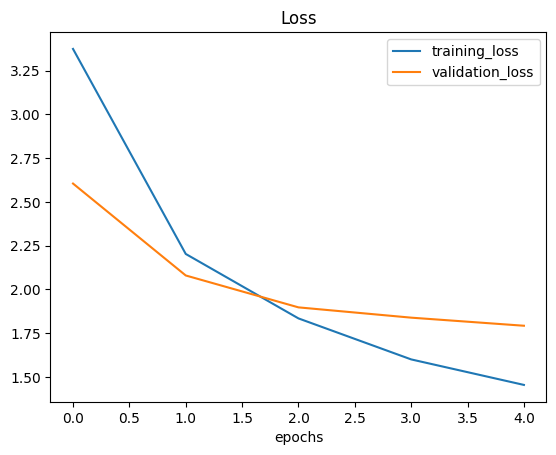

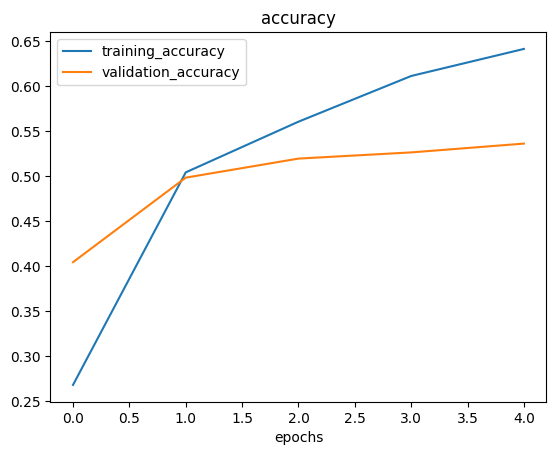

In [ ]:
plot_loss_curve(history)

In [ ]:
# unfreezing the layers
base_model.trainable=True

for layers in base_model.layers[:-5]:
  layers.trainable=False


In [ ]:
for i ,layers in enumerate(model.layers):
  print(i,layers.name,layers.trainable)

0 input_11 True
1 data_argumentation True
2 efficientnetb0 True
3 global_average_pooling True
4 output_layer True


In [ ]:
for i ,layers in enumerate(model.layers[2].layers):
  print(i,layers.name,layers.trainable)

0 input_12 False
1 rescaling_10 False
2 normalization_5 False
3 rescaling_11 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze F

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 60s 76ms/step - loss: 1.5720 - accuracy: 0.5874


[1.5719547271728516, 0.5874059200286865]

In [ ]:

# for fine tuning we need to add extra 5 epochs
#already we fit the weights to the model_2 so we want to start training after the previous 5 epoch(already readed the data five times now we going to read from the 5th epoch not from starting)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_1=model.fit(train_data,
            epochs=10,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=int(0.15*len(test_data)),
            initial_epoch=history.epoch[-1],#start training from previous epoch
            )

Epoch 5/10
237/237 [==============================] - 83s 307ms/step - loss: 1.4802 - accuracy: 0.6024 - val_loss: 1.6472 - val_accuracy: 0.5646
Epoch 6/10
237/237 [==============================] - 66s 277ms/step - loss: 1.0766 - accuracy: 0.7036 - val_loss: 1.8346 - val_accuracy: 0.5334
Epoch 7/10
237/237 [==============================] - 61s 255ms/step - loss: 0.8312 - accuracy: 0.7633 - val_loss: 1.8029 - val_accuracy: 0.5392
Epoch 8/10
237/237 [==============================] - 61s 254ms/step - loss: 0.6457 - accuracy: 0.8157 - val_loss: 2.1826 - val_accuracy: 0.4852
Epoch 9/10
237/237 [==============================] - 61s 256ms/step - loss: 0.5181 - accuracy: 0.8417 - val_loss: 1.8247 - val_accuracy: 0.5516
Epoch 10/10
237/237 [==============================] - 56s 237ms/step - loss: 0.4285 - accuracy: 0.8772 - val_loss: 1.9588 - val_accuracy: 0.5522


In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 59s 75ms/step - loss: 1.7978 - accuracy: 0.5816


[1.7977968454360962, 0.5815841555595398]

In [ ]:
def compare_history(original_history,finetuning_history,initial_epochs):
  acc=original_history.history["accuracy"]
  val_acc=original_history.history["val_accuracy"]
  loss=original_history.history["loss"]
  val_loss=original_history.history["val_loss"]

  total_acc= acc+finetuning_history.history["accuracy"]
  total_val_acc= val_acc+finetuning_history.history["val_accuracy"]
  total_loss= loss+finetuning_history.history["loss"]
  total_val_loss= val_loss+finetuning_history.history["val_loss"]


  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc,label="Training Accuracy")
  plt.plot(total_val_acc,label=" val_Accuracy")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend()
  plt.title("training and validation Accuracy")

  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss,label="Training Loss")
  plt.plot(total_val_loss,label=" val_Loss")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend()
  plt.title("Training and Validation loss")


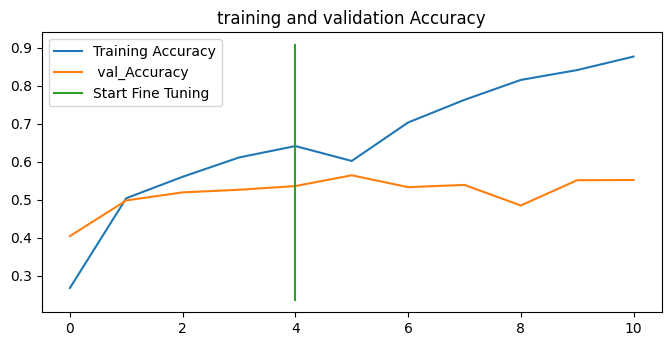

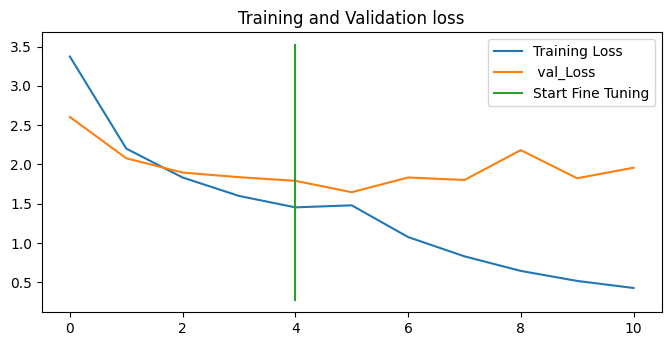

In [ ]:
compare_history(history,history_1,5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')